In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm import tqdm
import random

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from utils import set_random_seed
set_random_seed(seed=0)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Encoder, self).__init__()
        self.fc = nn.Linear(784, 512)
        # two separate fc layers for mean and variance
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_log_sd = nn.Linear(512, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # input x: [B, 784]
        x = F.tanh(self.fc(x)) # [B, latent_dim]
        # Compute mean and logarithm of sd
        # (use logarithm to produce negative values)
        mu =  self.fc_mu(x) # [B, latent_dim]
        log_var = self.fc_log_sd(x) # [B, latent_dim]
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.tanh(self.fc1(z))
        z = F.tanh(self.fc2(z))
        return z
    

class VAE(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mu, log_var = self.encoder(x)
        # log(var) = log(sd**2)
        # sd**2 = exp(log(var))
        # sd = exp(0.5*log(var))
        z = self.reparameterization_trick(mu=mu, sd=torch.exp(0.5*log_var))
        x_hat = self.decoder(z)
        return x_hat, mu, log_var
    
    def reparameterization_trick(self, mu: torch.Tensor, sd: torch.Tensor) -> torch.Tensor:
        eps = torch.randn_like(mu) # sample from N(0,I)
        z = mu + sd * eps
        return z
    
    def reconstruction_loss(self, x: torch.Tensor, x_hat: torch.Tensor) -> torch.Tensor:
        """
        We want to maximize the quality of reconstruction (minimize MSE).
        """
        mse = torch.sum((x - x_hat)**2) # by batch
        return mse
    
    def kl_divergence(self, mu: torch.Tensor, sd: torch.Tensor) -> torch.Tensor:
        """
        We want to minimize KL divergence between the learned distribution 
        of z-space and the prior distribution of z-space.
        """
        kl_distance = 0.5 * torch.sum(1 + torch.log(sd**2) - mu**2 - sd**2) # by batch
        return -kl_distance
    
    def reg_weights_loss_fn(self, lam: float) -> float:
        learnable_weights = [p for p in self.parameters() if p.requires_grad and p.dim() > 1]
        loss = lam * torch.sum(torch.tensor([torch.sum(w**2) for w in learnable_weights]))
        return loss

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # [0,1]
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)) # [-1,1]
])

dataset = torchvision.datasets.MNIST(root='../../data/', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True, drop_last=True)

for x, _ in tqdm(dataloader):
    break

  0%|          | 0/468 [00:00<?, ?it/s]


In [6]:
epochs = 5
latent_dim = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAE(latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    for batch, (x, _) in enumerate(dataloader):
        
        x = torch.flatten(x, start_dim=1, end_dim=-1) # [B, 1, 784]
        x = x.to(device)
        x_hat, mu, log_var = model(x) # x_hat: [B, 1, 784]

        reconstruction_loss = model.reconstruction_loss(x=x, x_hat=x_hat)
        kl_divergence = model.kl_divergence(mu=mu, sd=torch.exp(0.5*log_var))
        reg_weights_loss = model.reg_weights_loss_fn(lam=1e-2)
        total_loss = reconstruction_loss + kl_divergence + reg_weights_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print(
                f"epoch={epoch}",
                f"batch={batch:03d}",
                f"mse={reconstruction_loss.item():.3f}",
                f"kl={kl_divergence.item():.3f}",
                f"reg_weights={reg_weights_loss.item():.3f}",
                f"total_loss={total_loss.item():.3f}"
            )

    print()

epoch=0 batch=000 mse=99954.914 kl=124.578 reg_weights=6.148 total_loss=100085.641
epoch=0 batch=100 mse=13335.990 kl=2868.020 reg_weights=7.252 total_loss=16211.262
epoch=0 batch=200 mse=10544.492 kl=3130.420 reg_weights=7.936 total_loss=13682.849
epoch=0 batch=300 mse=9548.301 kl=3227.761 reg_weights=8.458 total_loss=12784.521
epoch=0 batch=400 mse=9496.994 kl=3273.161 reg_weights=8.910 total_loss=12779.064

epoch=1 batch=000 mse=9131.489 kl=3404.303 reg_weights=9.210 total_loss=12545.003
epoch=1 batch=100 mse=8891.594 kl=3415.573 reg_weights=9.651 total_loss=12316.818
epoch=1 batch=200 mse=9106.172 kl=3393.421 reg_weights=10.109 total_loss=12509.702
epoch=1 batch=300 mse=7870.437 kl=3371.330 reg_weights=10.592 total_loss=11252.358
epoch=1 batch=400 mse=7926.220 kl=3463.077 reg_weights=11.097 total_loss=11400.396

epoch=2 batch=000 mse=8485.421 kl=3455.829 reg_weights=11.450 total_loss=11952.700
epoch=2 batch=100 mse=8215.371 kl=3542.932 reg_weights=11.986 total_loss=11770.288
epoch=

In [7]:
x.size(), x_hat.size(), mu.size(), log_var.size()

(torch.Size([128, 784]),
 torch.Size([128, 784]),
 torch.Size([128, 16]),
 torch.Size([128, 16]))

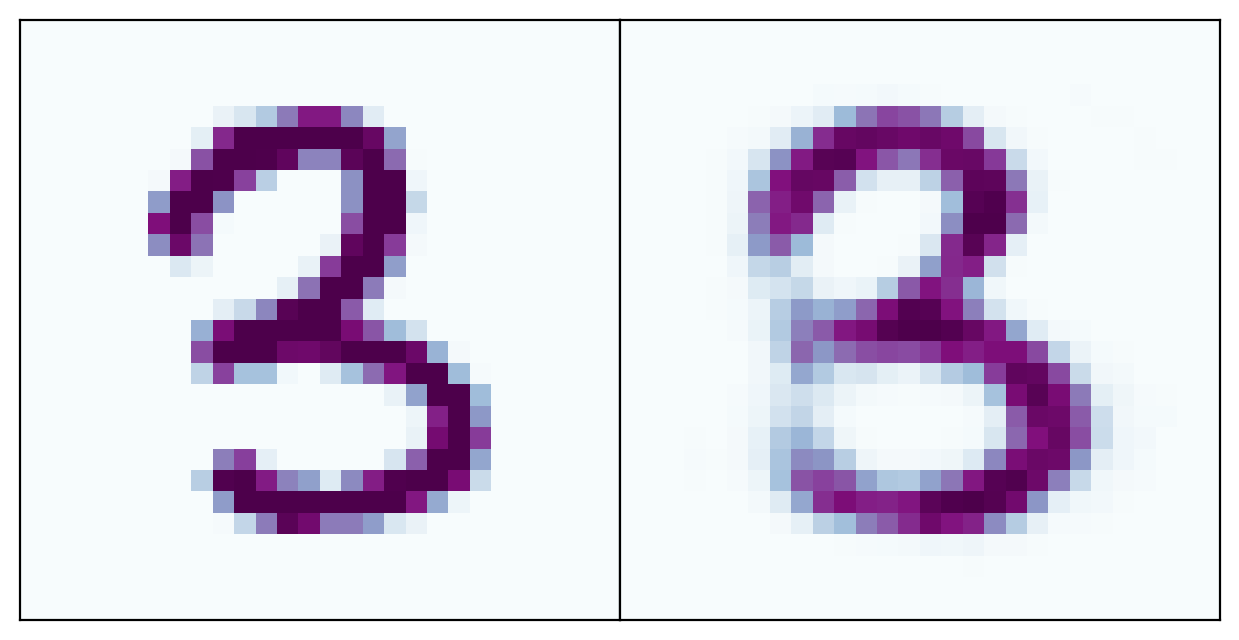

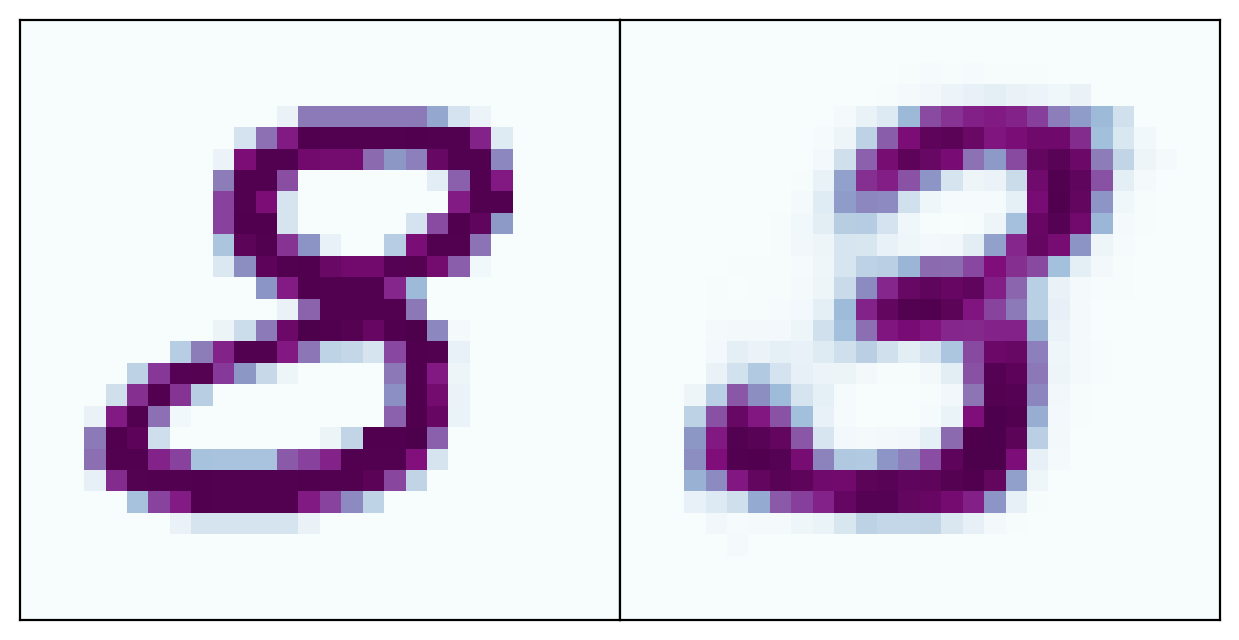

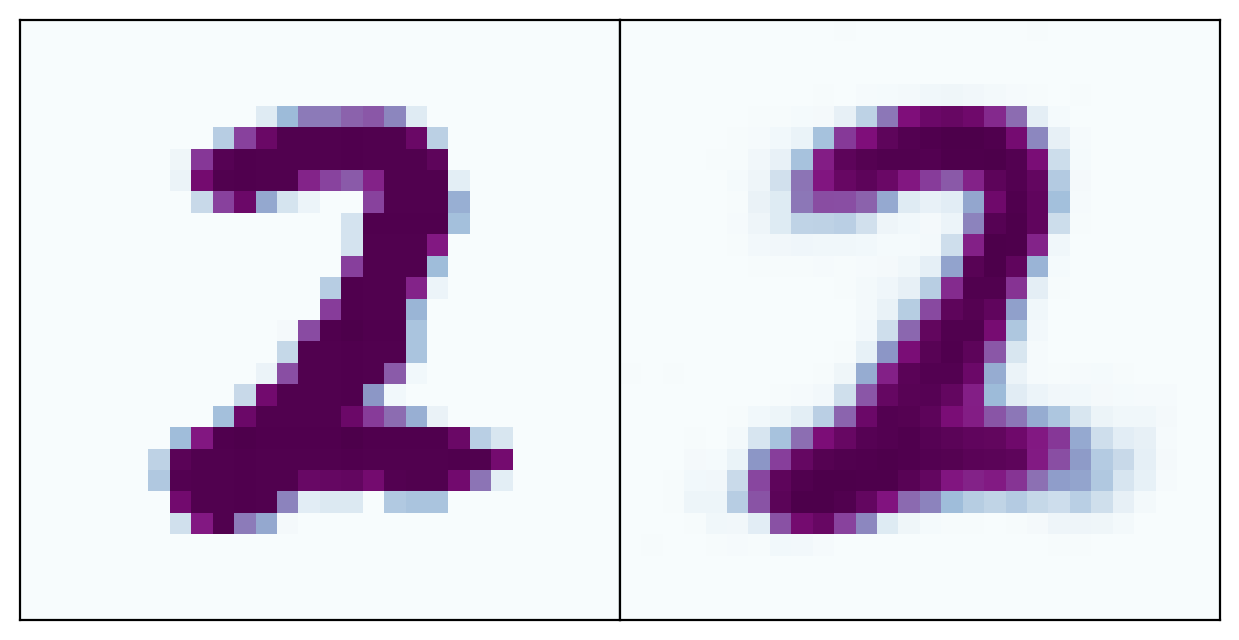

In [8]:
set_random_seed(seed=0)
imgs = [dataset[r] for r in random.sample(range(30_000), 3)]

for img, label in imgs:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(img.view(28,28), cmap='BuPu');

    img_hat, _, _ = model(img.view(1,1,784).to(device))
    ax2.imshow(img_hat.view(28,28).cpu().detach(), cmap='BuPu');
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()

# Morphing

In [9]:
imgs = [
    dataset[1][0][0],
    dataset[3][0][0],
    dataset[5][0][0],
    dataset[7][0][0],
    dataset[9][0][0],
    dataset[0][0][0],
    dataset[13][0][0],
    dataset[15][0][0],
    dataset[55][0][0],
    dataset[33][0][0],
    dataset[1][0][0], # 9 -> 0
]

In [10]:
params = []
for img in imgs:
    mu, log_sd = model.encoder(img.reshape(1, 784))
    params.append((mu, log_sd))

In [11]:
eps = torch.randn_like(mu)

STEPS = 20

decoded = []
for i in range(len(params) - 1):
    mu_prev, log_sd_prev = params[i]
    mu_next, log_sd_next = params[i+1]
    
    mu_delta = (mu_next - mu_prev) / STEPS
    log_sd_delta = (log_sd_next - log_sd_prev) / STEPS

    mu_increment = 0
    log_sd_increment = 0
    for i in range(STEPS):
        
        mu = mu_prev + mu_increment
        mu_increment += mu_delta
        
        log_sd = log_sd_prev + log_sd_increment
        log_sd_increment += log_sd_delta

        z = mu + torch.exp(log_sd) * eps
        output = model.decoder(z)
        output = output.view(28,28).cpu().detach()
        decoded.append(output)

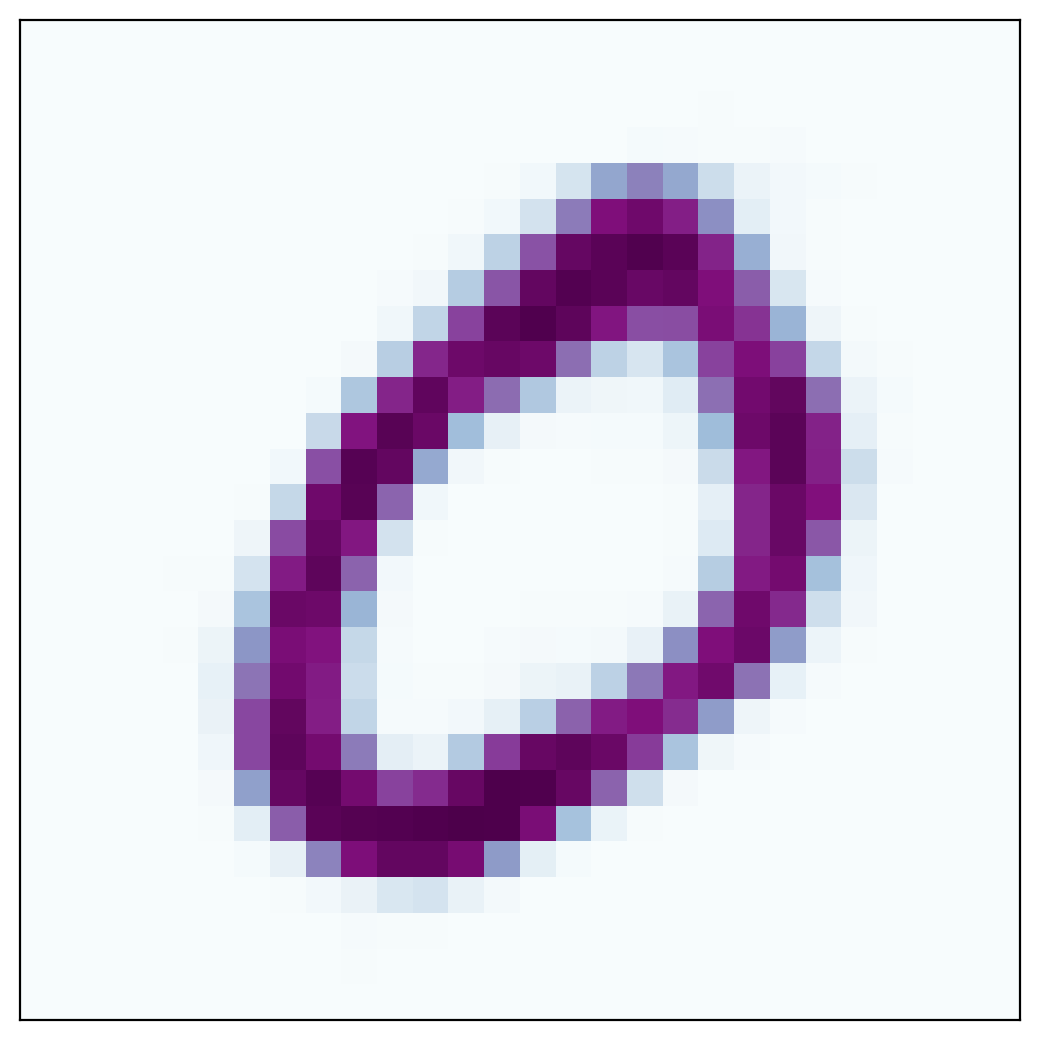

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

def animate(i):
    ax.clear()
    f = ax.imshow(decoded[i], cmap='BuPu')
    ax.set_xticks([])
    ax.set_yticks([])
    return f

ani = FuncAnimation(fig=fig, func=animate, repeat=True, frames=len(decoded))
ani.save("animation_mnist.gif", dpi=100, writer=PillowWriter(fps=10))